In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import os

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

In [4]:
col_labels = ['Female', 'Age', 'Physical Activity', 'Serum Albumin',
       'Alkaline Phosphatase', 'SGOT', 'BUN', 'Calcium', 'Creatinine',
       'Potassium', 'Sodium', 'Total Bilirubin', 'Serum Protein',
       'Red Blood Cells', 'White Blood Cells', 'Hemoglobin', 'Hematocrit',
       'Normal Platelets', 'Increased Platelets', 'Decreased Platelets',
       'Segmented Neutrophils', 'Lymphocytes', 'Monocytes', 'Eosinophils',
       'Basophils', 'Band Neutrophils', 'Cholesterol',
       'Negative Urine Albumin', 'Urine Albumin above 30',
       'Urine Albumin above 100', 'Urine Albumin above 300',
       'Urine Albumin above 1000', 'Urine Albumin Trace',
       'Negative Urine Glucose', 'Light Urine Glucose',
       'Medium Urine Glucose', 'Dark Urine Glucose',
       'Very Dark Urine Glucose', 'Urine Glucose Trace', 'Urine pH',
       'Negative Urine Hematest', 'Urine Hematest Small',
       'Urine Hematest Moderate', 'Urine Hematest Large',
       'Urine Hematest Very Large', 'Urine Hematest Trace',
       'Sedimentation Rate', 'Uric Acid', 'Systolic BP',
       'Pulse Pressure', 'BMI']

In [5]:
shap_blue = shap.plots.colors.blue_rgb
shap_red = shap.plots.colors.red_rgb
shap_gray = shap.plots.colors.gray_rgb
shap_cmap = shap.plots.colors.red_blue

In [6]:
X = pd.read_csv('data/X_large.csv')
y = np.load('data/y_new.npy')

In [7]:
(X_train, X_test, y_train, y_test) = train_test_split(X,y,test_size=0.2,random_state=42)

In [8]:
RF_grid = joblib.load('Results/RF_grid.pkl')
Base_grid = joblib.load('Results/RPF_Baseline_L2_Xlarge.pkl')
os.chdir(sys.path[0])
RPF_grid = joblib.load('Results/RPF_Interactions_L2_Xlarge.pkl')
os.chdir(sys.path[0])

In [9]:
rf_train_pred = RF_grid.best_estimator_.predict_proba(X_train)
rf_test_pred = RF_grid.best_estimator_.predict_proba(X_test)
base_train_pred = np.load('Results/train_proba_L2_base.npy')
base_test_pred = np.load('Results/test_proba_L2_base.npy')
rpf_train_pred = np.load('Results/train_proba_L2_int.npy')
rpf_test_pred = np.load('Results/test_proba_L2_int.npy')

In [10]:
imputer = RF_grid.best_estimator_['imputer']

In [11]:
results_rf = pd.DataFrame(RF_grid.cv_results_)
results_rpf_base = pd.DataFrame(Base_grid.cv_results_)
results_rpf_int = pd.DataFrame(RPF_grid.cv_results_)

In [12]:
print('RF optimal parameters:')
for i in RF_grid.best_params_.items():
    print(i)
print('Baseline optimal parameters:')
for i in Base_grid.best_params_.items():
    print(i)
print('RPF optimal parameters:')
for i in RPF_grid.best_params_.items():
    print(i)

RF optimal parameters:
('randomforestclassifier__max_depth', 10)
('randomforestclassifier__max_features', 0.39923698042110656)
('randomforestclassifier__n_estimators', 771)
Baseline optimal parameters:
('randomplantedforestv3__n_trees', 48)
('randomplantedforestv3__split_try', 6)
('randomplantedforestv3__splits', 31)
('randomplantedforestv3__t_try', 0.39955563066436806)
RPF optimal parameters:
('randomplantedforestv3__max_interaction', 10)
('randomplantedforestv3__n_trees', 27)
('randomplantedforestv3__split_try', 14)
('randomplantedforestv3__splits', 39)
('randomplantedforestv3__t_try', 0.10121221776213585)


In [13]:
print('RF cv mean -log loss score:\n', RF_grid.best_score_)
print('Base cv mean -log loss score:\n', Base_grid.best_score_)
print('RPF cv mean -log loss score:\n', RPF_grid.best_score_)

RF cv mean -log loss score:
 -0.3834443562408366
Base cv mean -log loss score:
 -0.4113349929468179
RPF cv mean -log loss score:
 -0.3802788935779069


In [14]:
test_scores = pd.DataFrame({'Baseline': results_rpf_base.loc[results_rpf_base.rank_test_score == 1, :].filter(regex = 'split[0-4]_test_score').to_numpy()[0],
                            'RF':results_rf.loc[results_rf.rank_test_score == 1, :].filter(regex = 'split[0-4]_test_score').to_numpy()[0],
                            'RPF':results_rpf_int.loc[results_rpf_int.rank_test_score == 1, :].filter(regex = 'split[0-4]_test_score').to_numpy()[0]
                            }).melt(var_name = 'Model', value_name = 'Fold')

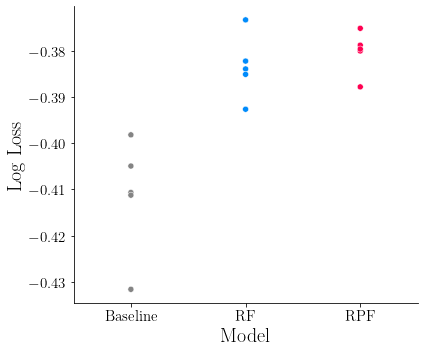

In [15]:
fig, ax = plt.subplots(1,1, figsize = (6,5))
sns.scatterplot(data = test_scores, x= 'Model', y = 'Fold', hue = 'Model', palette=(shap_gray, shap_blue, shap_red), legend=False)
ax.tick_params(axis = 'both', labelsize = 15)
ax.set_ylabel('Log Loss', fontsize = 20)
ax.set_xlabel('Model', fontsize = 20)
ax.set_xlim(-0.5,2.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('Figs/cv_log_loss_dist.png')
plt.show()

In [16]:
print('RF -log loss scores:\n train:', np.round(-log_loss(y_train, rf_train_pred), 5), 'test:', np.round(-log_loss(y_test, rf_test_pred),5))
print('Base -log loss scores:\n train:', np.round(-log_loss(y_train, base_train_pred), 5), 'test:', np.round(-log_loss(y_test, base_test_pred),5))
print('RPF -log loss scores:\n train:', np.round(-log_loss(y_train, rpf_train_pred), 5), 'test:', np.round(-log_loss(y_test, rpf_test_pred),5))

RF -log loss scores:
 train: -0.2711 test: -0.40981
Base -log loss scores:
 train: -0.40421 test: -0.45638
RPF -log loss scores:
 train: -0.36429 test: -0.40694


In [17]:
print('RF accuracy scores:\n train:', np.round(accuracy_score(y_train, np.argmax(rf_train_pred, axis=1)), 5), 'test:', np.round(accuracy_score(y_test, np.argmax(rf_test_pred, axis=1)),5))
print('Base accuracy scores:\n train:', np.round(accuracy_score(y_train, np.argmax(base_train_pred, axis=1)), 5), 'test:', np.round(accuracy_score(y_test, np.argmax(base_test_pred, axis=1)),5))
print('RPF accuracy scores:\n train:', np.round(accuracy_score(y_train, np.argmax(rpf_train_pred, axis=1)), 5), 'test:', np.round(accuracy_score(y_test, np.argmax(rpf_test_pred, axis=1)),5))

RF accuracy scores:
 train: 0.9083 test: 0.80625
Base accuracy scores:
 train: 0.83028 test: 0.80588
RPF accuracy scores:
 train: 0.83856 test: 0.81034


In [18]:
print('RF AUC scores:\n train:', np.round(roc_auc_score(y_train, rf_train_pred[:,1]),5), 'test:', np.round(roc_auc_score(y_test, rf_test_pred[:,1]),5))
print('Base AUC scores:\n train:', np.round(roc_auc_score(y_train, base_train_pred[:,1]),5), 'test:', np.round(roc_auc_score(y_test, base_test_pred[:,1]),5))
print('RPF AUC scores:\n train:', np.round(roc_auc_score(y_train, rpf_train_pred[:,1]),5), 'test:', np.round(roc_auc_score(y_test, rpf_test_pred[:,1]),5))

RF AUC scores:
 train: 0.94954 test: 0.85025
Base AUC scores:
 train: 0.87281 test: 0.84894
RPF AUC scores:
 train: 0.88381 test: 0.85141


In [19]:
rf_fpr, rf_tpr, rf_thresh = roc_curve(y_train, rf_train_pred[:,1])
base_fpr, base_tpr, base_thresh = roc_curve(y_train, base_train_pred[:,1])
rpf_fpr, rpf_tpr, rpf_thresh = roc_curve(y_train, rpf_train_pred[:,1])

rf_fpr_test, rf_tpr_test, rf_thresh_test = roc_curve(y_test, rf_test_pred[:,1])
base_fpr_test, base_tpr_test, base_thresh_test = roc_curve(y_test, base_test_pred[:,1])
rpf_fpr_test, rpf_tpr_test, rpf_thresh_test = roc_curve(y_test, rpf_test_pred[:,1])

In [20]:
rf_train_auc = np.round(roc_auc_score(y_train, rf_train_pred[:,1]),4)
rf_test_auc = np.round(roc_auc_score(y_test, rf_test_pred[:,1]),4)
base_train_auc = np.round(roc_auc_score(y_train, base_train_pred[:,1]),4)
base_test_auc = np.round(roc_auc_score(y_test, base_test_pred[:,1]),4)
rpf_train_auc = np.round(roc_auc_score(y_train, rpf_train_pred[:,1]),4)
rpf_test_auc = np.round(roc_auc_score(y_test, rpf_test_pred[:,1]),4)

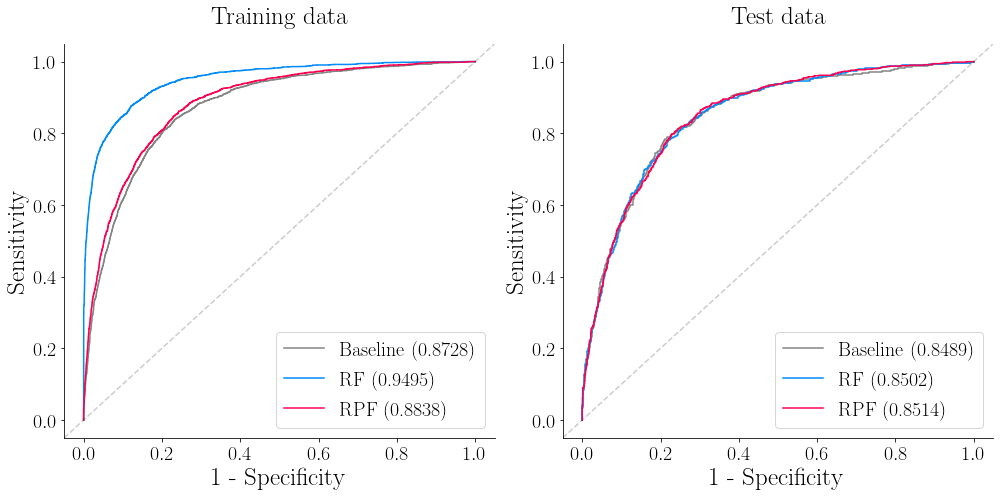

In [21]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (14,7))
ax1.plot(base_fpr, base_tpr, label = 'Baseline (' + str(base_train_auc) + ')', color = shap_gray)
ax1.plot(rf_fpr, rf_tpr, label = 'RF (' + str(rf_train_auc) + ')', color = shap_blue)
ax1.plot(rpf_fpr, rpf_tpr, label = 'RPF (' + str(rpf_train_auc) + ')', color = shap_red)
ax1.plot([0, 1], [0, 1], '--k', alpha = 0.2, transform=ax1.transAxes)
ax1.legend(fontsize = 20)
ax1.tick_params(axis = 'both', labelsize = 20)
ax1.set_xlabel('1 - Specificity', fontsize = 25)
ax1.set_ylabel('Sensitivity', fontsize = 25)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Training data', fontsize = 25, pad = 20)
ax2.plot(base_fpr_test, base_tpr_test, label = 'Baseline (' + str(base_test_auc) + ')', color = shap_gray)
ax2.plot(rf_fpr_test, rf_tpr_test, label = 'RF (' + str(rf_test_auc) + ')', color = shap_blue)
ax2.plot(rpf_fpr_test, rpf_tpr_test, label = 'RPF (' + str(rpf_test_auc) + ')', color = shap_red)
ax2.plot([0, 1], [0, 1], '--k', alpha = 0.2, transform=ax2.transAxes)
ax2.legend(fontsize = 20)
ax2.tick_params(axis = 'both', labelsize = 20)
ax2.set_xlabel('1 - Specificity', fontsize = 25)
ax2.set_ylabel('Sensitivity', fontsize = 25)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Test data', fontsize = 25, pad = 20)
fig.tight_layout()
plt.show()


In [22]:
train_pred = pd.DataFrame({'Base': base_train_pred[:,1], 'RF': rf_train_pred[:,1], 'RPF': rpf_train_pred[:,1], 'Class': y_train})
train_pred.loc[train_pred['Base']>1, 'Base'] = 1
train_pred.loc[train_pred['Base']<0, 'Base'] = 0
train_pred.loc[train_pred['RPF']>1, 'RPF'] = 1
train_pred.loc[train_pred['RPF']<0, 'RPF'] = 0

In [23]:
test_pred = pd.DataFrame({'Base': base_test_pred[:,1], 'RF': rf_test_pred[:,1], 'RPF': rpf_test_pred[:,1], 'Class': y_test})
test_pred.loc[test_pred['Base']>1, 'Base'] = 1
test_pred.loc[test_pred['Base']<0, 'Base'] = 0
test_pred.loc[test_pred['RPF']>1, 'RPF'] = 1
test_pred.loc[test_pred['RPF']<0, 'RPF'] = 0

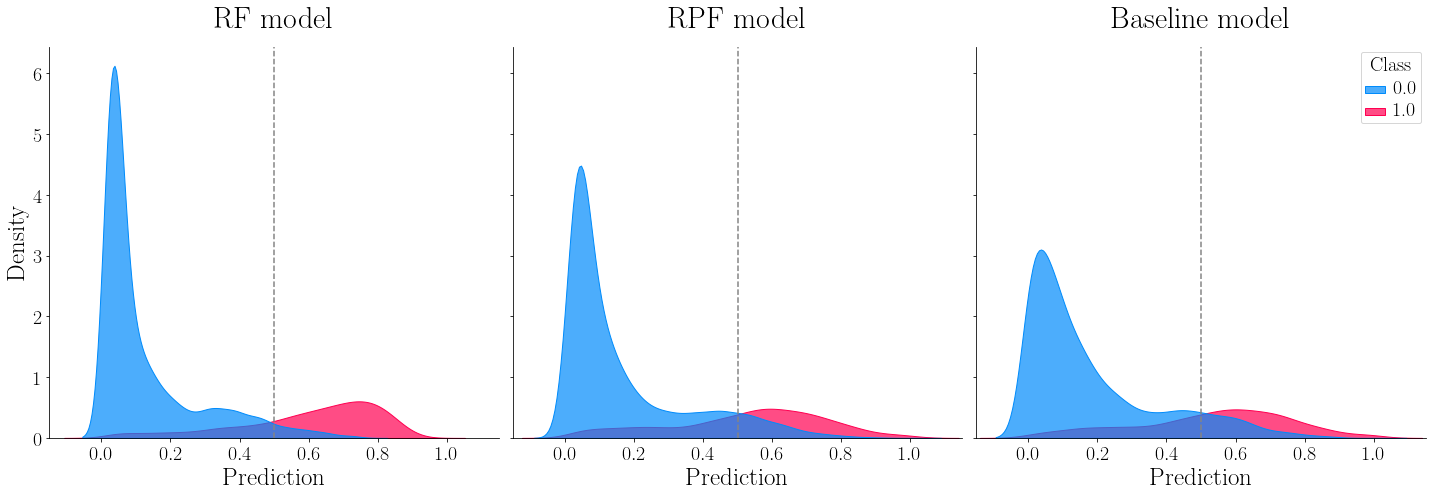

In [29]:
fig, ax = plt.subplots(1,3, figsize = (20,7), sharey=True)
ax1 = sns.kdeplot(x = train_pred.RF, hue = train_pred.Class, shade = True, palette = (shap_blue, shap_red), ax = ax[0], legend=False, alpha = 0.7)
ax1.axvline(x = 0.5,color = shap_gray, ls = '--')
ax1.set_xlabel('Prediction', fontsize = 25)
ax1.set_ylabel('Density', fontsize = 25)
ax1.set_title('RF model', fontsize = 30, pad = 20)
ax1.tick_params(axis = 'both', labelsize = 20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlim(-0.15, 1.15)
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax2 = sns.kdeplot(x = train_pred.RPF, hue = train_pred.Class, shade = True, palette = (shap_blue, shap_red), ax = ax[1], legend = False, alpha = 0.7)
ax2.axvline(x = 0.5,color = shap_gray, ls = '--')
ax2.set_xlabel('Prediction', fontsize = 25)
ax2.set_title('RPF model', fontsize = 30, pad = 20)
ax2.tick_params(axis = 'x', labelsize = 20)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlim(-0.15, 1.15)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax3 = sns.kdeplot(x = train_pred.Base, hue = train_pred.Class, shade = True, palette = (shap_blue, shap_red), ax = ax[2], alpha = 0.7)
ax3.axvline(x = 0.5,color = shap_gray, ls = '--')
ax3.set_xlabel('Prediction', fontsize = 25)
ax3.set_title('Baseline model', fontsize = 30, pad =20)
ax3.tick_params(axis = 'x', labelsize = 20)
plt.setp(ax3.get_legend().get_texts(), fontsize=20)
plt.setp(ax3.get_legend().get_title(), fontsize=20)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_xlim(-0.15, 1.15)
ax3.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
fig.tight_layout()
plt.show()

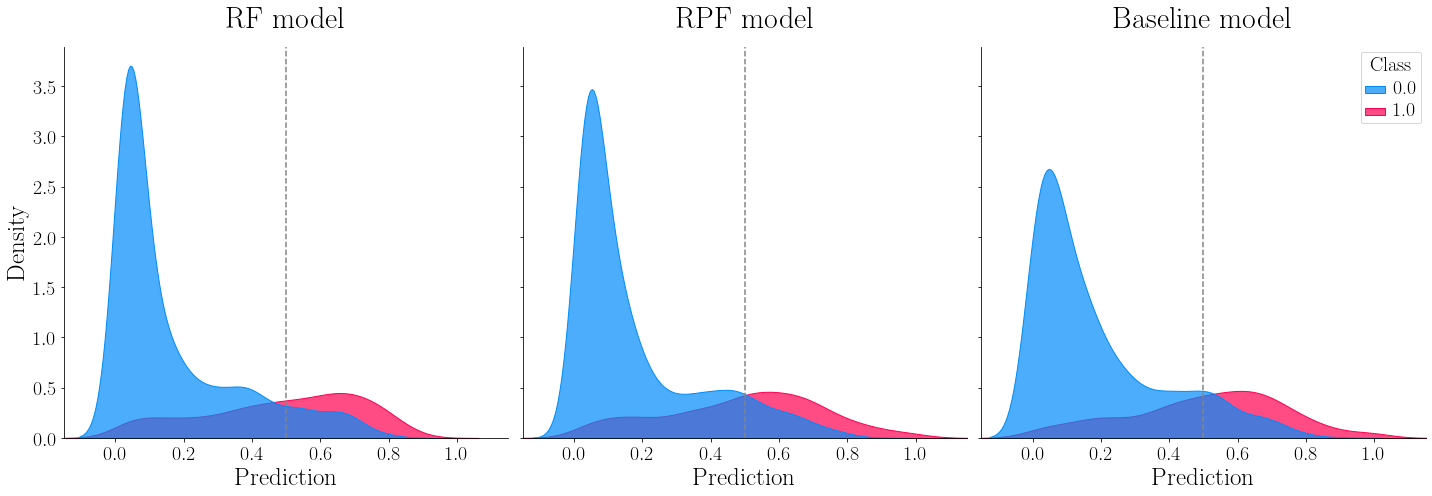

In [32]:
fig, ax = plt.subplots(1,3, figsize = (20,7), sharey=True)
ax1 = sns.kdeplot(x = test_pred.RF, hue = test_pred.Class, shade = True, palette = (shap_blue, shap_red), ax = ax[0], legend=False, alpha = 0.7)
ax1.axvline(x = 0.5,color = shap_gray, ls = '--')
ax1.set_xlabel('Prediction', fontsize = 25)
ax1.set_ylabel('Density', fontsize = 25)
ax1.set_title('RF model', fontsize = 30, pad = 20)
ax1.tick_params(axis = 'both', labelsize = 20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlim(-0.15, 1.15)
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax2 = sns.kdeplot(x = test_pred.RPF, hue = test_pred.Class, shade = True, palette = (shap_blue, shap_red), ax = ax[1], legend = False, alpha = 0.7)
ax2.axvline(x = 0.5,color = shap_gray, ls = '--')
ax2.set_xlabel('Prediction', fontsize = 25)
ax2.set_title('RPF model', fontsize = 30, pad = 20)
ax2.tick_params(axis = 'x', labelsize = 20)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlim(-0.15, 1.15)
ax2.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax3 = sns.kdeplot(x = test_pred.Base, hue = test_pred.Class, shade = True, palette = (shap_blue, shap_red), ax = ax[2], alpha = 0.7)
ax3.axvline(x = 0.5,color = shap_gray, ls = '--')
ax3.set_xlabel('Prediction', fontsize = 25)
ax3.set_title('Baseline model', fontsize = 30, pad =20)
ax3.tick_params(axis = 'x', labelsize = 20)
plt.setp(ax3.get_legend().get_texts(), fontsize=20)
plt.setp(ax3.get_legend().get_title(), fontsize=20)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_xlim(-0.15, 1.15)
ax3.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
fig.tight_layout()
plt.show()

In [33]:
train_pred_melt = train_pred.melt(id_vars='Class', var_name='Model', value_name='Pred')
test_pred_melt = test_pred.melt(id_vars='Class', var_name='Model', value_name='Pred')

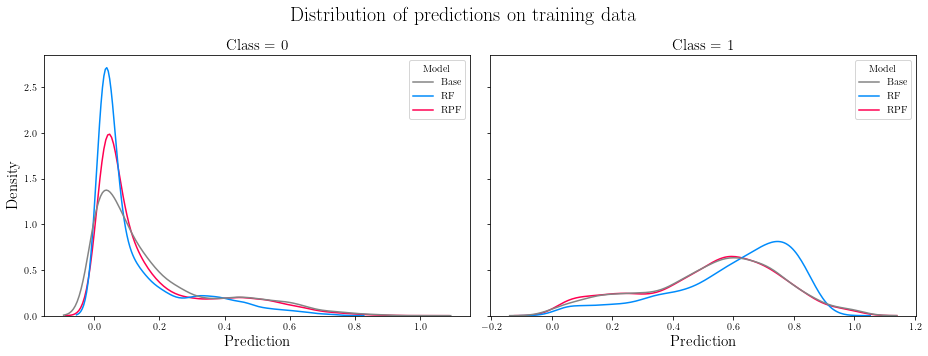

In [34]:
fig, ax = plt.subplots(1,2, figsize = (13,5), sharey = True)
ax1 = sns.kdeplot(x=train_pred_melt.Pred[train_pred_melt.Class == 0], hue = train_pred_melt.Model[train_pred_melt.Class == 0],
            palette = (shap_gray, shap_blue, shap_red), ax = ax[0])
ax1.set_ylabel('Density', fontsize = 15)
ax1.set_xlabel('Prediction', fontsize = 15)
ax1.set_title('Class = 0', fontsize = 15)
ax2 = sns.kdeplot(x=train_pred_melt.Pred[train_pred_melt.Class == 1], hue = train_pred_melt.Model[train_pred_melt.Class == 1],
            palette = (shap_gray, shap_blue, shap_red), ax = ax[1])
ax2.set_xlabel('Prediction', fontsize = 15)
ax2.set_title('Class = 1', fontsize = 15)
fig.suptitle('Distribution of predictions on training data', fontsize = 20)
fig.tight_layout()
plt.show()

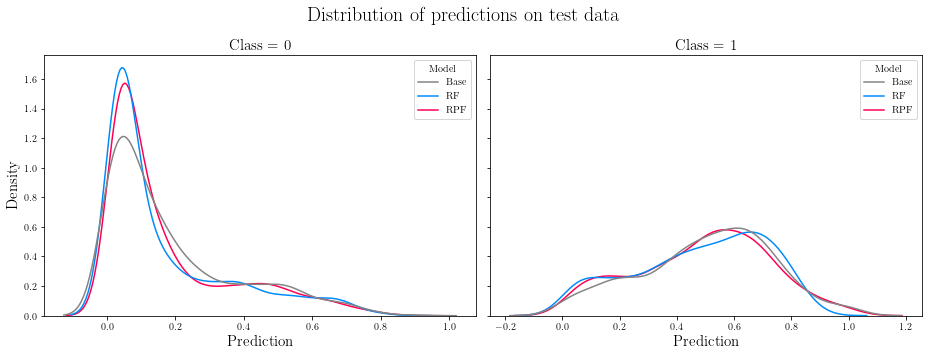

In [35]:
fig, ax = plt.subplots(1,2, figsize = (13,5), sharey = True)
ax1 = sns.kdeplot(x=test_pred_melt.Pred[test_pred_melt.Class == 0], hue = test_pred_melt.Model[test_pred_melt.Class == 0],
            palette = (shap_gray, shap_blue, shap_red), ax = ax[0])
ax1.set_ylabel('Density', fontsize = 15)
ax1.set_xlabel('Prediction', fontsize = 15)
ax1.set_title('Class = 0', fontsize = 15)
ax2 = sns.kdeplot(x=test_pred_melt.Pred[test_pred_melt.Class == 1], hue = test_pred_melt.Model[test_pred_melt.Class == 1],
            palette = (shap_gray, shap_blue, shap_red), ax = ax[1])
ax2.set_xlabel('Prediction', fontsize = 15)
ax2.set_title('Class = 1', fontsize = 15)
fig.suptitle('Distribution of predictions on test data', fontsize = 20)
fig.tight_layout()
plt.show()

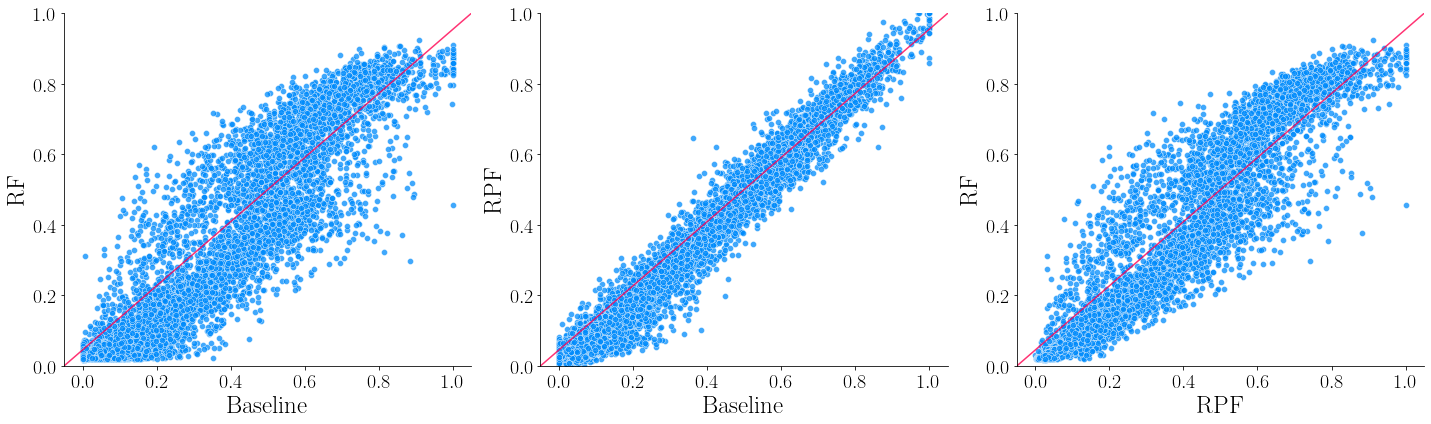

In [27]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
ax1 = sns.scatterplot(x = train_pred.Base,  y = train_pred.RF,color = shap_blue, alpha = 0.75, ax = ax[0])
ax1.set_ylim(0,1)
ax1.plot([0, 1], [0, 1],c = shap_red, alpha = 0.8, transform=ax1.transAxes)
ax1.set_xlabel('Baseline', fontsize = 25)
ax1.set_ylabel('RF', fontsize = 25)
ax1.tick_params(axis = 'both', labelsize = 20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = sns.scatterplot(x = train_pred.Base,  y = train_pred.RPF,color = shap_blue, alpha = 0.75, ax = ax[1])
ax2.set_ylim(0,1)
ax2.plot([0, 1], [0, 1],c = shap_red, alpha = 0.8, transform=ax2.transAxes)
ax2.set_xlabel('Baseline', fontsize = 25)
ax2.set_ylabel('RPF', fontsize = 25)
ax2.tick_params(axis = 'both', labelsize = 20)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = sns.scatterplot(x = train_pred.RPF,  y = train_pred.RF,color = shap_blue, alpha = 0.75, ax = ax[2])
ax3.set_ylim(0,1)
ax3.plot([0, 1], [0, 1],c = shap_red, alpha = 0.8, transform=ax3.transAxes)
ax3.set_xlabel('RPF', fontsize = 25)
ax3.set_ylabel('RF', fontsize = 25)
ax3.tick_params(axis = 'both', labelsize = 20)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
fig.tight_layout()
plt.show()

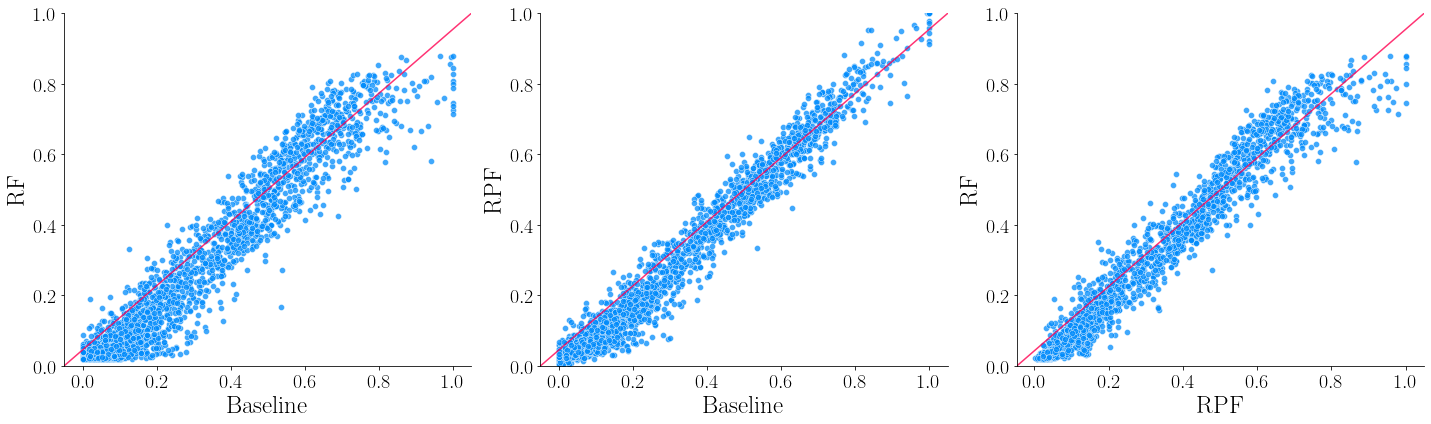

In [28]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
ax1 = sns.scatterplot(x = test_pred.Base,  y = test_pred.RF,color = shap_blue, alpha = 0.75, ax = ax[0])
ax1.set_ylim(0,1)
ax1.plot([0, 1], [0, 1],c = shap_red, alpha = 0.8, transform=ax1.transAxes)
ax1.set_xlabel('Baseline', fontsize = 25)
ax1.set_ylabel('RF', fontsize = 25)
ax1.tick_params(axis = 'both', labelsize = 20)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = sns.scatterplot(x = test_pred.Base,  y = test_pred.RPF,color = shap_blue, alpha = 0.75, ax = ax[1])
ax2.set_ylim(0,1)
ax2.plot([0, 1], [0, 1],c = shap_red, alpha = 0.8, transform=ax2.transAxes)
ax2.set_xlabel('Baseline', fontsize = 25)
ax2.set_ylabel('RPF', fontsize = 25)
ax2.tick_params(axis = 'both', labelsize = 20)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = sns.scatterplot(x = test_pred.RPF,  y = test_pred.RF,color = shap_blue, alpha = 0.75, ax = ax[2])
ax3.set_ylim(0,1)
ax3.plot([0, 1], [0, 1],c = shap_red, alpha = 0.8, transform=ax3.transAxes)
ax3.set_xlabel('RPF', fontsize = 25)
ax3.set_ylabel('RF', fontsize = 25)
ax3.tick_params(axis = 'both', labelsize = 20)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
fig.tight_layout()
plt.show()